# UC2 Comparison Supervised model vs MoCo model

In [4]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
from torchvision.models import resnet18
from collections import OrderedDict
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np

from represent.tools.plots import plot_confusion_matrix
from represent.datamodules.uc2_landcover_datamodule import UC2LandCoverDataModule

## MOCO model (for reference)

In [5]:
from argparse import ArgumentParser
import pytorch_lightning as pl
from represent.models.uc2_supervised_resnet import UC2ResNet
from represent.tools.utils import seed_all
from pl_bolts.models.regression import LogisticRegression

config = dict(
    data_dir = "/data/RepreSent/UC2",
    seed = 42,
    batch_size = 64,
    image_size = 610,
    backbone = "resnet18",
    simplified_classes = False,
    segmentation = False,
    gpus = 1,
    accelerator="gpu",
    strategy = None,
    workers = 16,
    max_epochs = 20,
    learning_rate = 0.001, #0.00019498445997580445 All Moco
    use_mlp = True,
    num_classes = 26,
    input_ch = 13,
    checkpoint = "/home/marc/projects/represent/represent/weights/uc2_moco_resnet18.pth",
    #checkpoint = "/home/marc/projects/represent/represent/weights/uc2_supervised_resnet18.pth"
#    checkpoint = "represent/represent/weights/simclr_resnet50.pth"
)

parser = ArgumentParser()
parser = pl.Trainer.add_argparse_args(parser)
parser = UC2ResNet.add_model_specific_args(parser)
parser = UC2LandCoverDataModule.add_model_specific_args(parser)

args, arg_strings = parser.parse_known_args([], None)
for key, value in config.items():
    setattr(args, key, value)

seed_all(config['seed'])


classifier = LogisticRegression(input_dim=2048, num_classes=config['num_classes'])
classifier = classifier.linear

args.classification_head = torch.nn.Linear(512, config['num_classes'])

model = UC2ResNet(**args.__dict__)

Global seed set to 42


In [6]:
model.load_from_checkpoint(config['checkpoint'])

<All keys matched successfully>

In [7]:
from tqdm.notebook import tqdm

keep_classes = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20, 22, 23, 24])

datamodule = UC2LandCoverDataModule.from_argparse_args(args, keep_classes=keep_classes, batch_size=128)

datamodule.setup(stage="test")

preds = []
targets = []

model.to("cuda")
model.eval()

for batch in tqdm(datamodule.test_dataloader()):
    x, y_true = batch
    x, y_true = x.to('cuda'), y_true.to('cuda')
    y_pred = model(x)
    
    # map back to original class ids
    y_true = keep_classes[y_true.detach().cpu().numpy()]
    
    preds.append(y_pred.argmax(1).detach().cpu().numpy())
    targets.append(y_true)
    

preds = np.concatenate(preds)
targets = np.concatenate(targets)

  0%|          | 0/1007 [00:00<?, ?it/s]

                                       precision    recall  f1-score   support

                                River       0.61      0.79      0.69       587
               Tree Plantations Large       0.00      0.00      0.00       324
                        Forest Closed       0.65      0.74      0.70     50833
                          Forest Open       0.50      0.47      0.48     34914
                        Shrubs Closed       0.38      0.35      0.36     21724
           Grasslands Closed Acquatic       0.77      0.19      0.31      1897
                     Urban - Built Up       0.89      0.15      0.25       334
                          Shrubs Open       0.19      0.04      0.06      1921
                    Grasslands Closed       0.49      0.31      0.38      6177
Agriculture flooded - Graminoid Small       0.00      0.00      0.00        85
               Herbaceous Crops Small       0.59      0.79      0.68      9048
                    Shrub Crops Small       0.00   

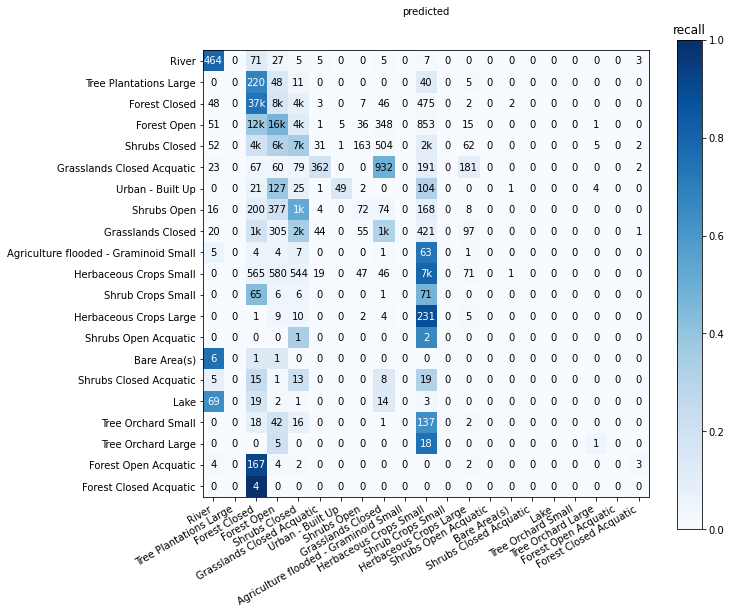

In [8]:
from represent.tools.plots import plot_confusion_matrix
from sklearn.metrics import classification_report
from represent.datamodules.uc2_landcover_datamodule import CLASSNAMES

plot_confusion_matrix(targets, preds, CLASSNAMES)

target_names = [CLASSNAMES[k] for k in keep_classes]
print(classification_report(targets, preds, zero_division=0, labels=keep_classes, target_names=target_names))

## Supervised Model

In [9]:
from argparse import ArgumentParser
import pytorch_lightning as pl
from represent.models.uc2_supervised_resnet import UC2ResNet
from represent.tools.utils import seed_all
from pl_bolts.models.regression import LogisticRegression

config = dict(
    data_dir = "/data/RepreSent/UC2",
    seed = 42,
    batch_size = 64,
    image_size = 610,
    backbone = "resnet18",
    simplified_classes = False,
    segmentation = False,
    gpus = 1,
    accelerator="gpu",
    strategy = None,
    workers = 16,
    max_epochs = 20,
    learning_rate = 0.001, #0.00019498445997580445 All Moco
    use_mlp = False,
    num_classes = 21,
    input_ch = 13,
    checkpoint = "../represent/weights/uc2_supervised_resnet18.pth",
    #checkpoint = "/home/marc/projects/represent/represent/weights/uc2_supervised_resnet18.pth"
#    checkpoint = "represent/represent/weights/simclr_resnet50.pth"
)

parser = ArgumentParser()
parser = pl.Trainer.add_argparse_args(parser)
parser = UC2ResNet.add_model_specific_args(parser)
parser = UC2LandCoverDataModule.add_model_specific_args(parser)

args, arg_strings = parser.parse_known_args([], None)
for key, value in config.items():
    setattr(args, key, value)

seed_all(config['seed'])


#args.classification_head = torch.nn.Linear(512, config['num_classes'])

model = UC2ResNet(**args.__dict__)

Global seed set to 42


In [10]:
model.load_from_checkpoint(config['checkpoint'])

<All keys matched successfully>

  0%|          | 0/1007 [00:00<?, ?it/s]

                                       precision    recall  f1-score   support

                                River       0.67      0.72      0.69       587
               Tree Plantations Large       0.02      0.03      0.02       324
                        Forest Closed       0.64      0.49      0.56     50833
                          Forest Open       0.35      0.30      0.33     34914
                        Shrubs Closed       0.25      0.17      0.20     21724
           Grasslands Closed Acquatic       0.30      0.42      0.35      1897
                     Urban - Built Up       1.00      0.01      0.01       334
                          Shrubs Open       0.08      0.01      0.02      1921
                    Grasslands Closed       0.13      0.72      0.22      6177
Agriculture flooded - Graminoid Small       0.00      0.00      0.00        85
               Herbaceous Crops Small       0.58      0.38      0.46      9048
                    Shrub Crops Small       0.00   

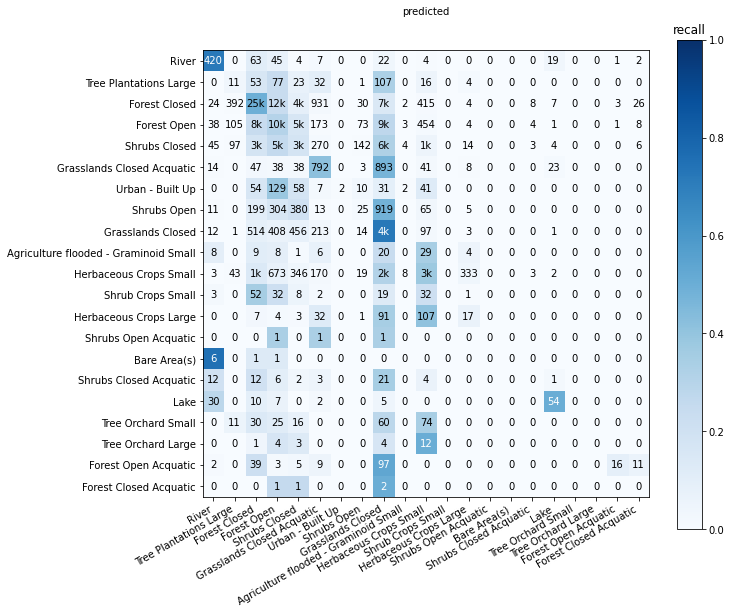

In [11]:

datamodule = UC2LandCoverDataModule.from_argparse_args(args, keep_classes=keep_classes, batch_size=128)

datamodule.setup(stage="test")

preds = []
targets = []

model.to("cuda")
model.eval()

for batch in tqdm(datamodule.test_dataloader()):
    x, y_true = batch
    x, y_true = x.to('cuda'), y_true.to('cuda')
    y_pred = model(x)
    
    # map back to original class ids
    y_true = keep_classes[y_true.detach().cpu().numpy()]
    
    preds.append(y_pred.argmax(1).detach().cpu().numpy())
    targets.append(y_true)
    

preds = np.concatenate(preds)
targets = np.concatenate(targets)

preds = keep_classes[preds]

plot_confusion_matrix(targets, preds, CLASSNAMES)

target_names = [CLASSNAMES[k] for k in keep_classes]
print(classification_report(targets, preds, zero_division=0, labels=keep_classes, target_names=target_names))